In [2]:
import os
from Bio import SeqIO
import glob

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, clear_output

from pandas.errors import EmptyDataError

import subprocess

In [3]:
from scipy.stats import spearmanr

### Commands
Getting the ribosomal protein fasta file for annotation
```
wget http://ftp.pasteur.fr/pub/gensoft/projects/growthpred/originalataset_ribproteins.tar.gz
tar -xzf originalataset_ribproteins.tar.gz
cat RibosomalProteins/* > RibosomalProteins.fasta
makeblastdb -in RibosomalProteins.fasta -input_type nucl -title RibosomalProteins
```

In [12]:
# Retrieve a list of fastas
query_fastas = glob.glob('/data/mhoffert/genomes/GTDB_r207/protein_fna_reps/bacteria/*')
len(query_fastas)

62291

In [74]:
# run commands to blast each genome's .fna file against the protein fasta
db_path = '/data/mhoffert/fiererlab/periodic_phyla/data/RibosomalProteins.fasta'
for i, query_file in enumerate(query_fastas):
    display(i)
    clear_output(wait=True)
    output_file = query_file.replace('protein_fna_reps/bacteria', 'blast_growthpred').replace('_protein.fna', '_blastout.txt')
    blast_command_str = f'blastn -db {db_path} -query {query_file} -out {output_file} -evalue 0.01 -num_threads 16 -outfmt "6 qseqid sseqid pident length mismatch gapopen qlen qstart qend slen sstart send evalue bitscore strand qcovs" -strand both'
    gzip_command_str = f'gzip {output_file}'
    
    os.system(blast_command_str)
    os.system(gzip_command_str)

62290

In [16]:
blast_results = glob.glob('/data/mhoffert/genomes/GTDB_r207/blast_growthpred/*_blastout.txt.gz')

In [17]:
len(blast_results)

62291

In [18]:
import itertools

In [19]:
# parsing results, annotating genomes for gRodon input, and plotting
blast_cols = 'qseqid sseqid pident length mismatch gapopen qlen qstart qend slen sstart send evalue bitscore qcovs'.split(' ')
nt_fasta_base_path = '/data/mhoffert/genomes/GTDB_r207/protein_fna_reps/bacteria/'
num_ribosomal_orfs = []
empty_files = []
evalues = [0.01,  0.00001]
qcovs = [30, 50, 90, 99]

for i, blast_file in enumerate(blast_results):
    
    if i % 100 == 0:
        display(i)
        clear_output(wait=True)
    
    # get genome id
    genome_id = blast_file.split('/')[-1].split('_blast')[0]
    
    # if not os.path.exists(f'/data/mhoffert/genomes/GTDB_r207/grodon_format/{genome_id}_grodon_format.fna'):
        # read and subset to 99% qcov columns
    try:
        df = pd.read_csv(blast_file, sep='\t', header=None)
        df.columns = blast_cols
        # Get the ribosomal ORFs
        ribosomal_orfs = df[df['qcovs'] >= 50]['qseqid'].unique()

        # add number of ribosomal ORFs to a list for plotting
        for e, q in itertools.product(evalues, qcovs):
            tup = (genome_id, e, q, len(df[(df['qcovs'] >= q) & (df['evalue'] <= e)]['qseqid'].unique()))
            num_ribosomal_orfs.append(tup)

#         nt_fasta = f'{nt_fasta_base_path}{genome_id}_protein.fna'

#         # read fasta
#         with open(nt_fasta, 'r') as input_fasta:
#             records = [r for r in SeqIO.parse(input_fasta, 'fasta')]

#         # modify IDs of ribosomal ORFs
#         for r in records:
#             if r.id in ribosomal_orfs:
#                 r.id = f'{r.id} ribosomal_protein'
#                 r.description = ' '.join(r.description.split(' ')[1:])

#         # write new file
#         with open(f'/data/mhoffert/genomes/GTDB_r207/grodon_format/{genome_id}_grodon_format.fna', 'w') as out_handle:
#                 SeqIO.write(records, out_handle, 'fasta')
                
#         os.system(f'gzip /data/mhoffert/genomes/GTDB_r207/grodon_format/{genome_id}_grodon_format.fna')

    except EmptyDataError:
        num_ribosomal_orfs.append((genome_id, '', '', -1))
        empty_files.append(blast_file)

62200

(-5.0, 65.0)

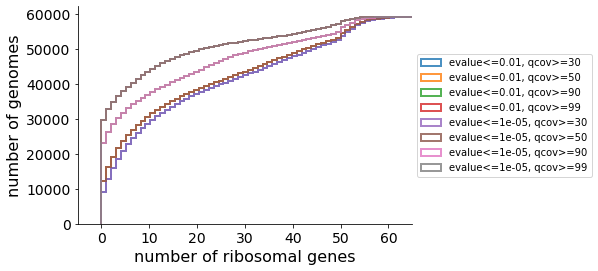

In [259]:
# plot
cumplot_data = pd.DataFrame(num_ribosomal_orfs, columns=['evalue', 'qcov', 'count'])

fig, ax  = plt.subplots(figsize=(6,4))
palette = sns.color_palette('tab10', n_colors=len(list(itertools.product(evalues, qcovs))))
for i, vals in enumerate(itertools.product(evalues, qcovs)):
    e,q=vals
    plt.hist(x=cumplot_data[cumplot_data.evalue.eq(e) & cumplot_data.qcov.eq(q)]['count'], bins=np.linspace(0, 101, 100), cumulative=True,
         histtype='step', alpha=0.8, label=f'evalue<={e}, qcov>={q}', color=palette[i], linewidth=2)

sns.despine()
ax.set_ylabel('number of genomes', fontsize=16)
ax.set_xlabel('number of ribosomal genes', fontsize=16)
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(labelsize=14)
ax.set_xlim(-5, 65)

In [265]:
cumplot_data.to_csv('/data/mhoffert/fiererlab/periodic_phyla/results/ribosomal_gene_cumplot_data.tsv', sep='\t')

### Supplementary Figures

In [20]:
gtdb_md = pd.read_csv('/data/mhoffert/genomes/GTDB_r207/bac120_metadata_r207.tsv', sep='\t', index_col=0)


Columns (61,65,74,82,83,85) have mixed types. Specify dtype option on import or set low_memory=False.


In [22]:
plotdf = pd.DataFrame(num_ribosomal_orfs)

In [34]:
x_data = pd.cut(gtdb_md[gtdb_md.gtdb_representative.eq('t')]['checkm_completeness'], np.linspace(20, 100, 9))
y_data = plotdf.set_index(0)[3]

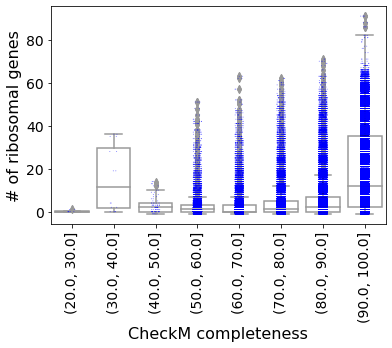

In [43]:
fig, ax = plt.subplots(figsize=(6,4))
sns.stripplot(x=x_data, 
              y=y_data, color='blue', alpha=0.5, s=1)
sns.boxplot(x=x_data, 
              y=y_data, color='white')
plt.xticks(rotation=90)
plt.tick_params(labelsize=14)
ax.set_ylabel('# of ribosomal genes', fontsize=16)
ax.set_xlabel('CheckM completeness', fontsize=16)
plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/figures/supplementary_figures/ribosomal_genes_vs_completeness.png', 
            dpi=400,
            bbox_inches='tight')

In [28]:
gtdb_md[gtdb_md.gtdb_representative.eq('t')]['checkm_completeness']

accession
GB_GCA_000012145.1    100.00
GB_GCA_000024525.1    100.00
GB_GCA_000169995.1     96.26
GB_GCA_000209515.2     99.57
GB_GCA_000238815.2     99.56
                       ...  
RS_GCF_904063065.1    100.00
RS_GCF_904846615.1     99.86
RS_GCF_905220835.1     99.80
RS_GCF_907164905.1    100.00
RS_GCF_910593725.1     64.08
Name: checkm_completeness, Length: 62291, dtype: float64

### Plotting relationships between # ribosomal proteins and genome metadata

In [14]:
n_genes = []
for i, qfasta in enumerate(query_fastas):
    if i % 100 == 0:
        display(i)
        clear_output(wait=True)
    result = subprocess.check_output(f'grep ">" {qfasta} | wc -l', shell=True).decode().strip()
    n_genes.append(result)

In [247]:
n_genes_series = pd.Series(data=[int(n) for n in n_genes], index=[s.split('/')[-1].split('_protein')[0] for s in query_fastas], dtype=np.int64)

Text(0.5, 0, 'n_genes (log10)')

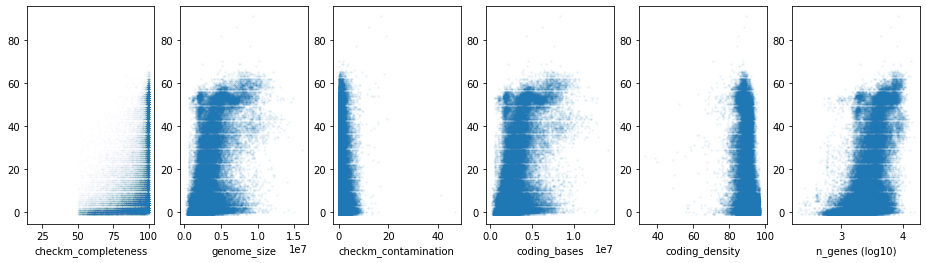

In [252]:
fig = plt.figure(figsize=(16,4))
i, n = 1, 6
s=5
ax = fig.add_subplot(1, n, i )
sns.scatterplot(x=gtdb_md[gtdb_md.gtdb_representative.eq('t')]['checkm_completeness'], y=num_blast_series, linewidth=0, alpha=0.01, s=s)
i += 1
ax = fig.add_subplot(1, n, i )
sns.scatterplot(x=gtdb_md[gtdb_md.gtdb_representative.eq('t')]['genome_size'], y=num_blast_series, linewidth=0, alpha=0.1, s=s)
i += 1
ax = fig.add_subplot(1, n, i )
sns.scatterplot(x=gtdb_md[gtdb_md.gtdb_representative.eq('t')]['checkm_contamination'], y=num_blast_series, linewidth=0, alpha=0.1, s=s)
i += 1
ax = fig.add_subplot(1, n, i )
sns.scatterplot(x=gtdb_md[gtdb_md.gtdb_representative.eq('t')]['coding_bases'], y=num_blast_series, linewidth=0, alpha=0.1, s=s)
i += 1
ax = fig.add_subplot(1, n, i )
sns.scatterplot(x=gtdb_md[gtdb_md.gtdb_representative.eq('t')]['coding_density'], y=num_blast_series, linewidth=0, alpha=0.1, s=s)
i += 1
ax = fig.add_subplot(1, n, i )
sns.scatterplot(x=n_genes_series.apply(np.log10), y=num_blast_series, linewidth=0, alpha=0.1, s=s)
ax.set_xlabel('n_genes (log10)')

### Read gRodon results

#### Notes
62,291 initial, 3053 with no hits for blast.

In [23]:
eggo_data = pd.read_csv('/data/mhoffert/tools/eggo/Data/EGGO.csv')

Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.


In [6]:
grodon_results = glob.glob('/data/mhoffert/fiererlab/periodic_phyla/results/gRodon_result_list*.tsv')

In [14]:
all_results = []
for result_file in grodon_results:
    grodon_df = pd.read_csv(result_file, index_col=0)
    grodon_df['genome'] = grodon_df['path'].apply(lambda x: x.split('/')[-1].split('_grodon_format')[0])
    all_results.append(grodon_df)

In [25]:
all_grodon_results = pd.concat(all_results)

In [26]:
all_grodon_results = all_grodon_results.groupby('genome').first().reset_index()

In [27]:
all_grodon_results['genome_short'] = all_grodon_results['genome'].apply(lambda x: '_'.join(x.split('_')[1:]))

In [37]:
eggo_measurements.index.isin(test_measurements.index).sum()

0

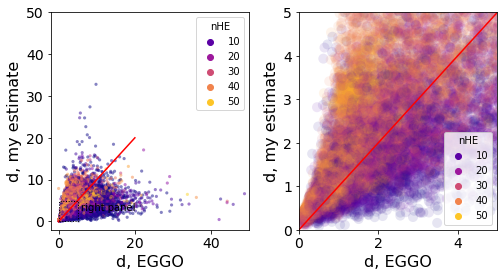

In [122]:
eggo_data['genome'] = eggo_data['Assembly'].apply(lambda x: '_'.join(x.split('_')[:2]))

eggo_measurements = eggo_data.groupby('genome').first()['d']
# eggo_measurements = eggo_measurements[eggo_measurements < 100]

test_measurements = all_grodon_results.set_index('genome_short')['d']
# test_measurements = test_measurements[test_measurements < 100]

shared = list(set(eggo_measurements[eggo_measurements < 100].index).intersection(set(test_measurements.index)))

hue = all_grodon_results.set_index('genome_short')['nHE'].reindex(shared)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(x=eggo_measurements.reindex(shared), 
                y=test_measurements.reindex(shared),
                hue=hue,
                palette='plasma',
                linewidth=0, alpha=0.5, s=10)
plt.plot((0, 20), (0, 20), color='r')
plt.tick_params(labelsize=14)
ax.set_ylabel('d, my estimate', fontsize=16)
ax.set_xlabel('d, EGGO', fontsize=16)
plt.plot((0, 0, 5, 5, 0), (0, 5, 5, 0, 0), color='k', linewidth=1, linestyle='dotted')
ax.set_xlim(-2, 50)
ax.set_ylim(-2, 50)
ax.annotate('right panel', xy=(6, 2.5), fontsize=10)

ax = fig.add_subplot(1,2,2)
sns.scatterplot(x=eggo_measurements.reindex(shared), 
                y=test_measurements.reindex(shared),
                hue=hue,
                palette='plasma',
                linewidth=0, alpha=0.1, s=100)
plt.plot((0, 20), (0, 20), color='r')
plt.tick_params(labelsize=14)
ax.set_ylabel('d, my estimate', fontsize=16)
ax.set_xlabel('d, EGGO', fontsize=16)
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
fig.subplots_adjust(wspace=0.25)

# plt.savefig('/data/mhoffert/realmichaelhoffert/ribosomal_proteins/figures/growth_rate_comparison.png', 
#             bbox_inches='tight', 
#             dpi=200)

In [123]:
difference_hist_data = eggo_measurements.reindex(shared) - test_measurements.reindex(shared)

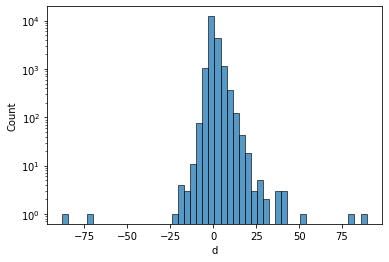

In [133]:
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(difference_hist_data, bins=50)
ax.set_yscale('log')

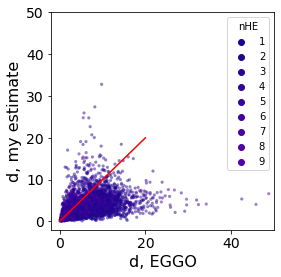

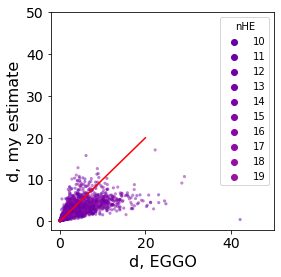

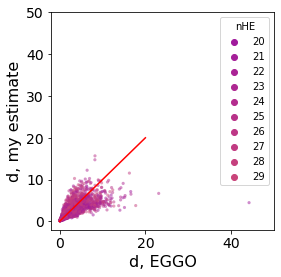

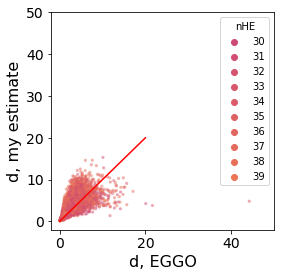

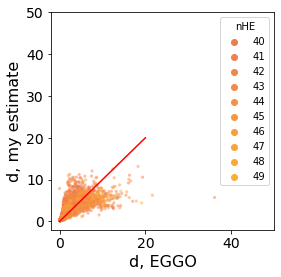

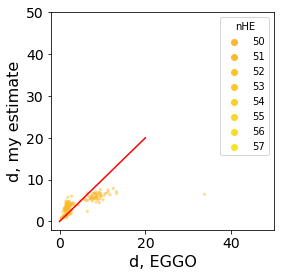

In [111]:
eggo_measurements = eggo_data.groupby('genome').first()['d']
# eggo_measurements = eggo_measurements[eggo_measurements < 100]
cutoffs = [0, 10, 20, 30, 40, 50]
palette = sns.color_palette('plasma', 60)

for i, cutoff in enumerate(cutoffs):

    test_measurements = all_grodon_results[(all_grodon_results.nHE >= cutoffs[i]) &
                                           (all_grodon_results.nHE < (cutoffs + [60])[i + 1])
                                          ].set_index('genome_short')['d']
    # test_measurements = test_measurements[test_measurements < 100]

    shared = list(set(eggo_measurements.index).intersection(set(test_measurements.index)))

    hue = all_grodon_results.set_index('genome_short')['nHE'].reindex(shared)

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1,1,1)
    if i == 0:
        curr_palette = palette[cutoffs[i]:cutoffs[i+1]-1]
    elif i == len(cutoffs) - 1:
        curr_palette = palette[cutoffs[i]:cutoffs[i]+ (hue.max() % cutoffs[i] + 1)]
    else:
        curr_palette = palette[cutoffs[i]:cutoffs[i+1]]
    
    
    sns.scatterplot(x=eggo_measurements.reindex(shared), 
                    y=test_measurements.reindex(shared),
                    hue=hue,
                    palette=curr_palette,
                    linewidth=0, alpha=0.5, s=10)
    plt.plot((0, 20), (0, 20), color='r')
    plt.tick_params(labelsize=14)
    ax.set_ylabel('d, my estimate', fontsize=16)
    ax.set_xlabel('d, EGGO', fontsize=16)
    # plt.plot((0, 0, 5, 5, 0), (0, 5, 5, 0, 0), color='k', linewidth=1, linestyle='dotted')
    ax.set_xlim(-2, 50)
    ax.set_ylim(-2, 50)
    plt.show()

In [134]:
new_shared = shared = list(set(eggo_measurements.index).intersection(set(all_grodon_results[all_grodon_results.nHE > 10].genome_short)))

spearmanr(eggo_measurements.reindex(shared), test_measurements.reindex(shared))

SpearmanrResult(correlation=0.7957508154483194, pvalue=0.0)

### Write results

In [141]:
genome_id_list = [s.split('/')[-1].split('_protein')[0] for s in query_fastas]

In [145]:
all_grodon_results.set_index('genome')['d'].reindex(genome_id_list).to_csv('/data/mhoffert/fiererlab/periodic_phyla/results/full_gtdb_growth_rate_predictions.tsv', sep='\t')

In [147]:
all_grodon_results.set_index('genome').to_csv('/data/mhoffert/fiererlab/periodic_phyla/results/gRodon_full_results_table.tsv', sep='\t')